<a href="https://colab.research.google.com/github/mohsenfaghih13/AOD/blob/main/04_pinn_hybrid_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 0, Total Loss: 0.659686 | PDE: 7.30e-03 | IC: 4.18e-01 | BC: 2.40e-02 | Data Loss: 2.10e-01 | Eval MSE: 1.64e-01 | Eval Rel. MSE: 1.40e+00
Epoch 200, Total Loss: 0.186677 | PDE: 3.04e-03 | IC: 9.95e-02 | BC: 4.29e-02 | Data Loss: 4.12e-02 | Eval MSE: 4.32e-02 | Eval Rel. MSE: 3.69e-01
Epoch 400, Total Loss: 0.152859 | PDE: 5.96e-03 | IC: 8.05e-02 | BC: 3.49e-02 | Data Loss: 3.14e-02 | Eval MSE: 3.25e-02 | Eval Rel. MSE: 2.77e-01
Epoch 600, Total Loss: 0.116666 | PDE: 8.90e-03 | IC: 5.14e-02 | BC: 3.22e-02 | Data Loss: 2.41e-02 | Eval MSE: 2.35e-02 | Eval Rel. MSE: 2.00e-01
Epoch 800, Total Loss: 0.097503 | PDE: 8.93e-03 | IC: 3.14e-02 | BC: 3.05e-02 | Data Loss: 2.66e-02 | Eval MSE: 2.51e-02 | Eval Rel. MSE: 2.14e-01
Epoch 1000, Total Loss: 0.090413 | PDE: 8.48e-03 | IC: 2.12e-02 | BC: 3.23e-02 | Data Loss: 2.84e-02 | Eval MSE: 2.63e-02 | Eval Rel. MSE: 2.25e-01
Epoch 1200, Total Loss: 0.088391 | PDE: 8.69e-03 | IC: 1.95e-02 | BC: 3.15e-02 | Data Loss: 2.87e-02 | Eval MSE: 2.68e-

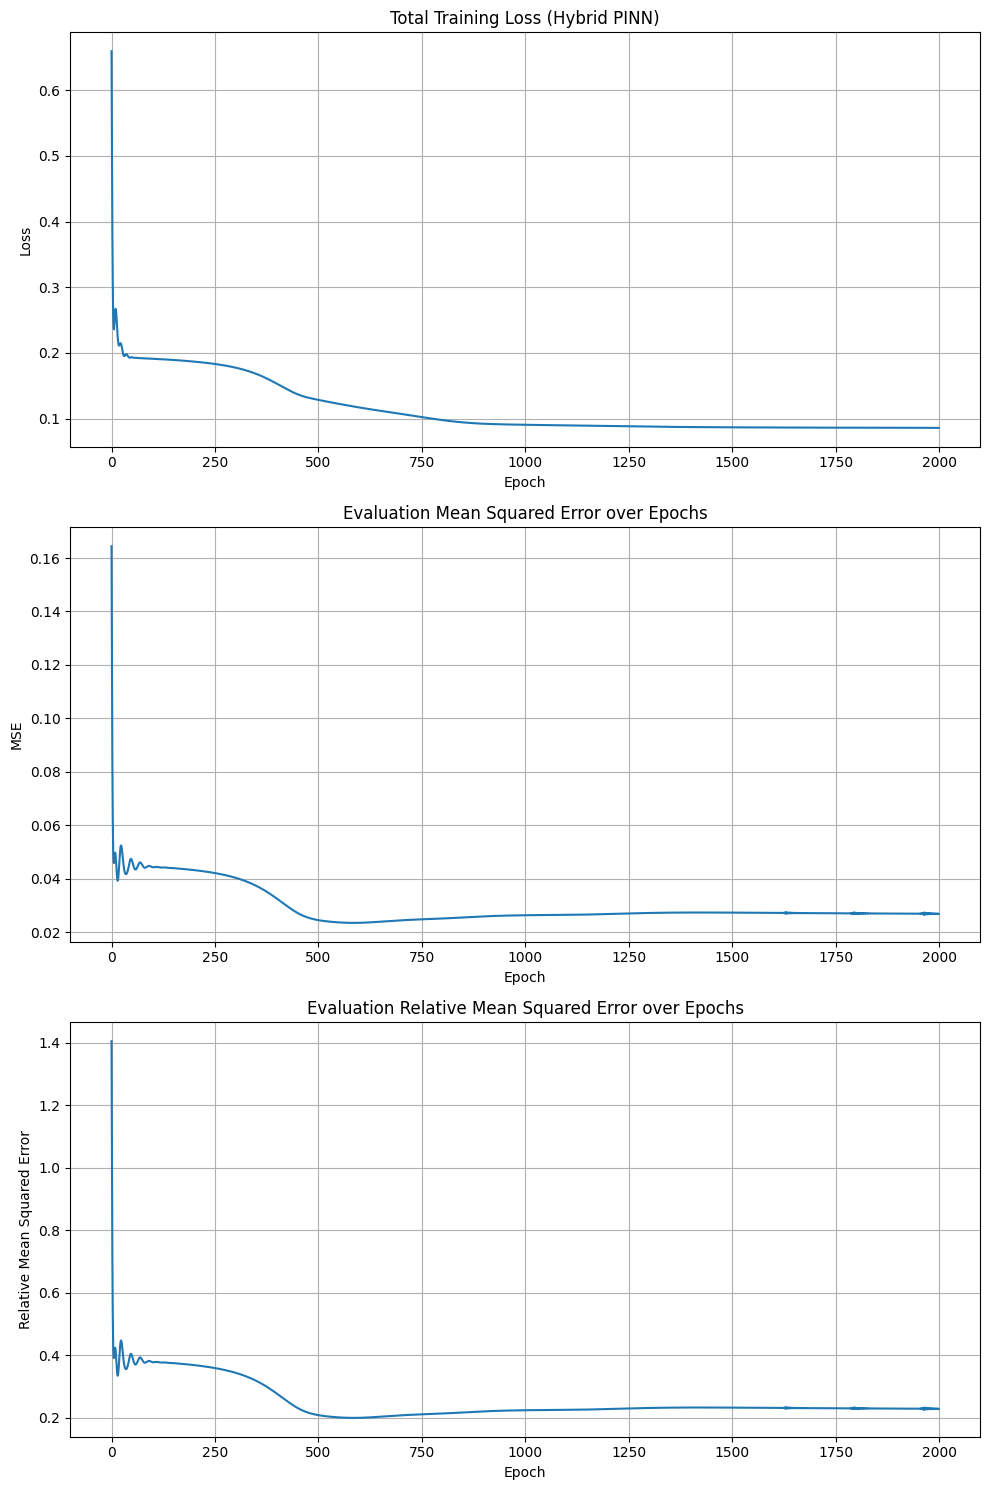

In [3]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

# A "fake" true solution
def true_solution(x, y, t):
    """
    This function acts as a known ground truth.
    It satisfies the initial and boundary conditions.
    """
    return torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.exp(-t)

# 1. Define PINN model
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, xyt):
        return self.net(xyt)

# 2. Compute derivatives using autograd
def derivatives(u, xyt):
    grad_u = autograd.grad(u, xyt, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = grad_u[:, 0:1]
    u_y = grad_u[:, 1:2]
    u_t = grad_u[:, 2:3]

    u_xx = autograd.grad(u_x, xyt, torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_yy = autograd.grad(u_y, xyt, torch.ones_like(u_y), create_graph=True)[0][:, 1:2]

    return u_t, u_x, u_y, u_xx, u_yy

# 3. PDE residual
def pde_residual(model, xyt, vx=1.0, vy=0.5, D=0.01):
    u = model(xyt)
    u_t, u_x, u_y, u_xx, u_yy = derivatives(u, xyt)
    return u_t + vx * u_x + vy * u_y - D * (u_xx + u_yy)

# 4. Generate training and evaluation data
def gen_data(Nf=1000, Nic=200, Nbc=200, Nd=200, N_eval=500):
    def rand_xy(N):
        x = torch.rand(N, 1)
        y = torch.rand(N, 1)
        return x, y
    def rand_t(N):
        return torch.rand(N, 1)
    def zeros_t(N):
        return torch.zeros(N, 1)

    # Interior points (collocation for PDE)
    xf, yf = rand_xy(Nf)
    tf = rand_t(Nf)
    xyt_f = torch.cat([xf, yf, tf], dim=1).requires_grad_()

    # Initial condition (t = 0)
    x0, y0 = rand_xy(Nic)
    t0 = zeros_t(Nic)
    xyt_ic = torch.cat([x0, y0, t0], dim=1).requires_grad_()
    u_ic = torch.sin(torch.pi * x0) * torch.sin(torch.pi * y0)

    # Boundary conditions
    tb = rand_t(Nbc)
    y_b1 = torch.rand(Nbc, 1)
    bc1 = torch.cat([torch.zeros(Nbc, 1), y_b1, tb], dim=1)  # x = 0
    bc2 = torch.cat([torch.ones(Nbc, 1), y_b1, tb], dim=1)  # x = 1
    x_b2 = torch.rand(Nbc, 1)
    bc3 = torch.cat([x_b2, torch.zeros(Nbc, 1), tb], dim=1)  # y = 0
    bc4 = torch.cat([x_b2, torch.ones(Nbc, 1), tb], dim=1)  # y = 1
    xyt_bc = torch.cat([bc1, bc2, bc3, bc4], dim=0).requires_grad_()

    # Data points from the "fake" true solution for TRAINING LOSS (Nd)
    xd, yd = rand_xy(Nd)
    td = rand_t(Nd)
    xyt_data = torch.cat([xd, yd, td], dim=1).requires_grad_()
    u_data = true_solution(xd, yd, td)

    # Data points for calculating MSE and REL during training (N_eval)
    # These are separate from Nd to ensure a fair evaluation set not directly used in data loss
    xe, ye = rand_xy(N_eval)
    te = rand_t(N_eval)
    xyt_eval = torch.cat([xe, ye, te], dim=1).requires_grad_()
    u_eval = true_solution(xe, ye, te) # This will be Utrue2test for metrics

    return xyt_f, xyt_ic, u_ic, xyt_bc, xyt_data, u_data, xyt_eval, u_eval

# 5. Training
model = PINN()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
lambda_data = 1.0 # Weight for the data loss

# Generate all data sets
xyt_f, xyt_ic, u_ic, xyt_bc, xyt_data, u_data, xyt_eval, u_eval = gen_data(Nd=500, N_eval=500)

loss_log = []
mse_log = []
rel_log = []

for epoch in range(2000):
    opt.zero_grad()

    # Physics-based loss
    f = pde_residual(model, xyt_f)
    loss_pde = (f**2).mean()

    # Boundary and Initial Condition losses
    u_pred_ic = model(xyt_ic)
    u_pred_bc = model(xyt_bc)
    loss_ic = ((u_pred_ic - u_ic)**2).mean()
    loss_bc = (u_pred_bc**2).mean()

    # Data-driven loss (using xyt_data and u_data)
    u_pred_data = model(xyt_data)
    loss_data = ((u_pred_data - u_data)**2).mean()

    # Total loss
    loss = loss_pde + loss_ic + loss_bc + lambda_data * loss_data
    loss.backward()
    opt.step()

    # Calculate and log evaluation metrics (using xyt_eval and u_eval)
    with torch.no_grad():
        u_pred_eval = model(xyt_eval) # This will be UNN2test for metrics

        # Your specified calculations for MSE and Relative MSE:
        point_square_error = torch.square(u_eval - u_pred_eval) # Utrue2test - UNN2test
        current_mse = torch.mean(point_square_error).item() # test_mse

        # Ensure denominator is not zero for Relative MSE
        mean_square_true = torch.mean(torch.square(u_eval)).item()
        current_rel = current_mse / mean_square_true if mean_square_true != 0 else float('inf')

    loss_log.append(loss.item())
    mse_log.append(current_mse)
    rel_log.append(current_rel)

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.6f} | PDE: {loss_pde.item():.2e} | IC: {loss_ic.item():.2e} | BC: {loss_bc.item():.2e} | Data Loss: {loss_data.item():.2e} | Eval MSE: {current_mse:.2e} | Eval Rel. MSE: {current_rel:.2e}")

# 6. Plot all metrics
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# Plot Total Loss
ax1.plot(loss_log)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Total Training Loss (Hybrid PINN)")
ax1.grid(True)

# Plot Mean Squared Error (MSE) on evaluation set
ax2.plot(mse_log)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("MSE")
ax2.set_title("Evaluation Mean Squared Error over Epochs")
ax2.grid(True)

# Plot Relative Mean Squared Error (Rel. MSE) on evaluation set
ax3.plot(rel_log)
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Relative Mean Squared Error")
ax3.set_title("Evaluation Relative Mean Squared Error over Epochs")
ax3.grid(True)

plt.tight_layout()
plt.show()